### import packages

python original packages or the third-party packages

In [1]:
import os
from dotenv import load_dotenv
import torch
import numpy as np
import matplotlib.pyplot as plt

personal defined modules in this project

In [2]:
from utils.config_utils import load_ddpm_config, load_dip_config, load_img_config, load_guide_dip_config
from utils.plot_utils import plot_snapshots, plot_sequence, plot_psnr
from utils.image_utils import load_image_to_tensor
from models.model import DDPM, DIP
from train.train_dip import train_dip

c:\Users\larry\Desktop\Pre-DDPM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load the config

In [3]:
config_path = "config.yaml"
load_dotenv()
DATA_ENTRY = str(os.getenv("DATA_ENTRY"))

image_path = os.path.join(DATA_ENTRY, "Image_1.jpg")

In [4]:
ddpm_config = load_ddpm_config(config_path)
dip_config = load_dip_config(config_path)
height, width = load_img_config(config_path)
guide_dip_config = load_guide_dip_config(config_path)

define how to plot two line together

In [5]:
def plot_twoline_comparisons(data1, data2, label1="PSNR", label2="MSE loss"):

    fig, ax1 = plt.subplots(figsize=(12, 4))


    ax1.plot(range(len(data1)), data1, 'r-', label=label1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel(f'{label1} Value', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()
    ax2.plot(range(len(data2)), data2, 'b-', label=label2)
    ax2.set_ylabel(f'{label2} Value', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    fig.tight_layout()
    plt.show()

### Parameters

load dip training iterations

In [6]:
num_steps = dip_config["num_steps"]

Given $count$ stages of noisy samples and assign different weights of training steps based on its level of noise

$$w_{i}=\frac{e^{-150\beta_{i}}}{e^{-150\beta_{1}}+e^{-150\beta_{2}}+...+e^{-150\beta_{count}}}$$
$$N_{i}=N*w_{i}$$

where $N$ is the total steps of Guided DIP

In [7]:
diffusion = DDPM(**ddpm_config)

In [8]:
timestamps = [ int(i) for i in np.linspace(guide_dip_config["start_t"], guide_dip_config["end_t"], guide_dip_config["count"]) ]
weights = [ np.exp(-150*diffusion.betas[t]) for t in timestamps ]
weights = weights / np.sum(weights)

print(f"each time in timestamps: {timestamps}")
print(f"each noise weights: {weights}")

steps = [ int(guide_dip_config["num_steps"] * w) for w in weights[:-1] ]
steps.append( num_steps - np.sum(steps) )

print(f"each noisy image train steps: {steps}")

each time in timestamps: [300, 271, 242, 213, 184, 155, 126, 97, 68, 40]
each noise weights: [0.065686   0.07163169 0.07811557 0.08518633 0.0928971  0.10130586
 0.11047573 0.12047563 0.1313807  0.14284539]
each noisy image train steps: [52, 57, 62, 68, 74, 81, 88, 96, 105, -383]


### Train DIP with small noise

In [9]:
clean_image = load_image_to_tensor(image_path, height, width)
target_image, _ = diffusion.forward_diffusion(clean_image, timestamps[-1])

model = DIP(dip_config["backbone_name"])

losses, snapshots, psnrs = train_dip(model, target_image, clean_image=clean_image, **dip_config)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:26<00:00, 11.51it/s]


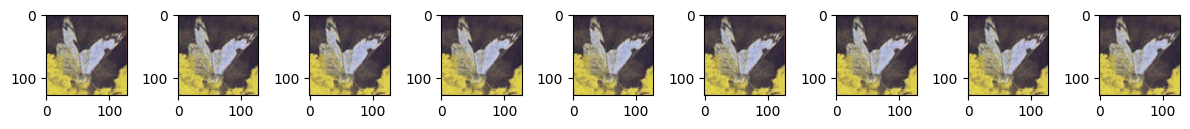

In [10]:
np.linspace(10, len(snapshots), 10)
plot_sequence(snapshots)

### Train DDPM Guided DIP

In [11]:
clean_image = load_image_to_tensor(image_path, height, width)
model = DIP(dip_config["backbone_name"])

collects = []
losses = []
snapshots = []
psnrs = []

for t in range(len(timestamps)):

    target_image, _ = diffusion.forward_diffusion(clean_image, timestamps[t])
    collects.append(target_image)

    guide_dip_config["num_steps"] = steps[t]

    loss, snapshot, psnr = train_dip(model, target_image, clean_image=clean_image, **guide_dip_config)
    losses.extend(loss)
    snapshots.extend(snapshot)
    psnrs.extend(psnr)

100%|██████████| 105/105 [00:08<00:00, 11.84it/s]
0it [00:00, ?it/s]
